In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from scipy.stats import zscore
from scipy import stats
from scipy.optimize import minimize, differential_evolution, NonlinearConstraint, LinearConstraint

from matplotlib import pyplot as plt
plt.style.use('./hockenberry.mplstyle')
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

###The following is used to create some sensible results folders according to the year/month
import datetime
year = datetime.date.today().year
month = datetime.date.today().month
import os
figs_dir = '../Results/Figures/{}_{:02}'.format(year, month)
if not os.path.exists(figs_dir):
    os.makedirs(figs_dir)

# Defining constants

In [3]:
sparse_data = False
save_figs = False

if sparse_data and save_figs:
    figs_dir += '/sparse_data'
    if not os.path.exists(figs_dir):
        os.makedirs(figs_dir)

In [4]:
###Synonymous substitution rates
# metric = 'codeml_ds_rp75_enterobacterales'
# metric = 'codeml_ds_rp75_enterobacteriacaea'

###Non-synonymous substitution rates
# metric = 'codeml_dn_rp75_enterobacterales'
metric = 'codeml_dn_rp75_enterobacteriacaea'

###dn/ds
# metric = 'codeml_dnds_rp75_enterobacterales'
# metric = 'codeml_dnds_rp75_enterobacteriacaea'

# plot_metric = 'ds'
plot_metric = 'dn'
# plot_metric = 'dnds'


if save_figs:
    figs_dir += '/{}'.format(plot_metric)
    if not os.path.exists(figs_dir):
        os.makedirs(figs_dir)

# Import data

In [5]:
full_df = pd.read_csv('../Data/ecoli_info/ecoli_evolutionary_rate_table.tsv', sep='\t', index_col=0)
print(full_df.shape)
full_df = full_df[full_df[metric].isnull()==False]
print(full_df.shape)
full_df = full_df[full_df[metric]>0.]
print(full_df.shape)
full_df.head()

(2365, 8)
(2309, 8)
(2306, 8)


,hyphy_rp75_enterobacterales,hyphy_rp75_enterobacteriacaea,codeml_dn_rp75_enterobacterales,codeml_ds_rp75_enterobacterales,codeml_dnds_rp75_enterobacterales,codeml_dn_rp75_enterobacteriacaea,codeml_ds_rp75_enterobacteriacaea,codeml_dnds_rp75_enterobacteriacaea
locus_tag,,,,,,,,
b3242,0.061857,0.041733,0.019432,0.430200,0.0452,0.008914,0.254165,0.0351
b3847,0.068649,0.044641,0.018641,0.286941,0.0649,0.007812,0.193456,0.0404
b3712,0.112357,0.107174,0.062285,0.573070,0.1087,0.037463,0.365068,0.1026
b2216,0.120750,0.101621,0.044529,0.416921,0.1068,0.021724,0.235298,0.0923
b1834,0.084874,0.064982,0.027663,0.341353,0.0810,0.015866,0.251659,0.0630


In [6]:
if sparse_data:
    meta_df = pd.read_csv('../Data/processed_data/processed_metadata_SPARSE.tsv', sep='\t', index_col=0)
else:
    meta_df = pd.read_csv('../Data/processed_data/processed_metadata.tsv', sep='\t', index_col=0)
print(meta_df.shape)
meta_df.head()

(103, 27)


,Sample ID,Study,Project ID,Condition ID,Strain Description,Strain,Base Media,Carbon Source (g/L),Nitrogen Source (g/L),Electron Acceptor,...,Additional Details,DOI,GEO,Simple_sample_id,Temperature (C),pH,Growth Rate (1/hr),Alignment,Replicate #,Doubling_time
4,fur__wt_fe__1,Fur,fur,wt_fe,Escherichia coli K-12 MG1655,MG1655,M9,glucose(2),NH4Cl(1),O2,...,NaN,doi.org/10.1038/ncomms5910,GSE54900,fur__wt_fe,37,7.0,1.060606,92.865,2,0.653539
8,fur__delfur_fe2__1,Fur,fur,delfur_fe2,Escherichia coli K-12 MG1655 del_fur,MG1655,M9,glucose(2),NH4Cl(1),O2,...,NaN,doi.org/10.1038/ncomms5910,GSE54900,fur__delfur_fe2,37,7.0,0.619469,93.020,2,1.118938
55,omics__bw_ac__1,Omics,omics,bw_ac,Escherichia coli BW25113,BW25113,M9,acetate(3.5),NH4Cl(1),O2,...,NaN,doi.org/10.1038/ncomms13091,GSE59759,omics__bw_ac,37,7.0,0.203000,97.920,2,3.414518
57,omics__bw_fum__1,Omics,omics,bw_fum,Escherichia coli BW25113,BW25113,M9,fumarate(2.8),NH4Cl(1),O2,...,NaN,doi.org/10.1038/ncomms13091,GSE59759,omics__bw_fum,37,7.0,0.309000,98.130,2,2.243195
59,omics__bw_glc__1,Omics,omics,bw_glc,Escherichia coli BW25113,BW25113,M9,glucose(5),NH4Cl(1),O2,...,NaN,doi.org/10.1038/ncomms13091,GSE59759,omics__bw_glc,37,7.0,0.607500,97.875,2,1.140983


In [7]:
if sparse_data:
    exp_df = pd.read_csv('../Data/processed_data/processed_expression_SPARSE.tsv', sep='\t', index_col=0)
else:
    exp_df = pd.read_csv('../Data/processed_data/processed_expression.tsv', sep='\t', index_col=0)
print(exp_df.shape)
exp_df.head()

(3923, 103)


,fur__wt_fe,fur__delfur_fe2,omics__bw_ac,omics__bw_fum,omics__bw_glc,omics__bw_pyr,cra_crp__wt_ac,cra_crp__wt_fru,cra_crp__delcra_ac,cra_crp__delcra_fru,...,pal__tartr_ale26_f10,pal__tartr_ale26,pal__tartr_ale28_f10,pal__tartr_ale28,efeU__menFentC_ale39,efeU__menFentC_ale29,efeU__menFentC_ale30,efeU__menFentCubiC_ale36,efeU__menFentCubiC_ale37,efeU__menFentCubiC_ale38
log-TPM,,,,,,,,,,,,,,,,,,,,,
b0002,10.921941,11.221916,9.219835,9.690669,10.213469,10.706351,9.568949,11.198040,8.487038,11.649292,...,7.907166,8.768993,7.738432,8.134838,10.344302,10.273946,11.159558,11.701351,11.902383,11.524586
b0003,10.687397,10.879548,8.963280,9.415289,9.643784,10.197705,8.831856,10.182029,8.546123,11.392722,...,8.026256,8.604928,7.832378,7.992993,10.265772,10.138576,10.353287,10.912852,11.031175,10.694248
b0004,10.254460,10.174903,8.770805,9.533522,9.876957,10.377069,8.680003,10.037740,7.748146,10.717654,...,8.090676,8.717934,7.802900,8.173352,10.712971,10.454710,10.701747,11.128015,11.213320,10.977106
b0005,6.563467,6.331911,4.597347,5.554385,5.909349,6.082721,4.576969,6.058802,3.399998,5.471490,...,3.684667,4.435953,4.044967,4.050593,6.245881,5.842332,6.298730,4.947044,5.603024,5.841291
b0006,6.789173,6.839814,6.488187,6.342374,6.876792,6.650875,6.273174,6.555468,6.647096,6.973928,...,6.635715,6.886069,6.236603,6.675508,7.161943,8.346839,8.104676,7.359833,7.321431,8.081482


In [8]:
if sparse_data:
    exp_summary_df = pd.read_csv('../Data/processed_data/processed_expression_summary_SPARSE.tsv', sep='\t', index_col=0)
else:
    exp_summary_df = pd.read_csv('../Data/processed_data/processed_expression_summary.tsv', sep='\t', index_col=0)


print(exp_summary_df.shape)
exp_summary_df.head()

(3923, 13)


,count,mean,std,min,25_percentile,50_percentile,75_percentile,max,cv,noise,lin_slope,lin_r,spearmans_rho
log-TPM,,,,,,,,,,,,,
b0002,103.0,10.028859,1.793338,0.056428,9.598118,10.504998,11.080190,12.361644,0.178818,0.031976,0.023834,0.150471,0.215259
b0003,103.0,9.776098,1.009884,7.265206,9.123471,10.023056,10.493901,11.883905,0.103301,0.010671,0.042490,0.151057,0.182895
b0004,103.0,9.849752,1.033603,7.371951,9.149693,10.104900,10.618291,11.992770,0.104937,0.011012,0.038633,0.140572,0.149976
b0005,103.0,5.550056,0.987474,1.878805,4.834444,5.705243,6.201346,7.551687,0.177922,0.031656,0.074243,0.258088,0.412982
b0006,103.0,6.851846,0.407601,5.285927,6.653258,6.849328,7.024589,8.346839,0.059488,0.003539,0.169540,0.243273,0.243724


In [9]:
full_df = full_df.merge(exp_summary_df, how='inner', left_index=True, right_index=True)

# Find the individual conditions whose gene expression is most (and least) correlated with CUB

ica__gth -0.34822344185631277
efeU__menFentC_ale30 -0.494202024478106


Text(0, 0.5, 'codeml_dn_rp75_enterobacteriacaea')

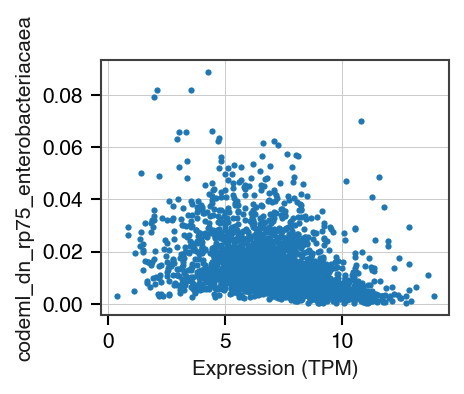

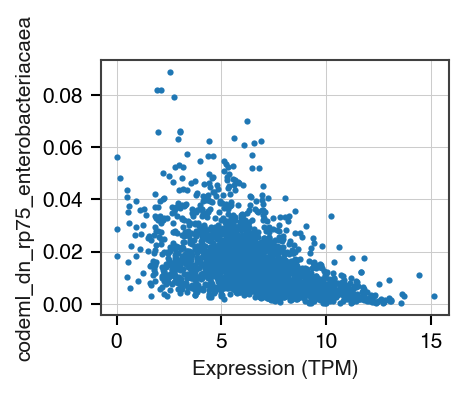

In [10]:
temp_df = exp_df.loc[full_df.index]
corrs = []
growth = []
min_r = 0
min_col = ''
max_r = -1
max_col = ''
for col in temp_df.columns:
    r, p = stats.pearsonr(full_df[metric], temp_df[col])
    corrs.append(r)
    assert meta_df[meta_df['Simple_sample_id']==col].shape[0]==1
    growth.append(meta_df[meta_df['Simple_sample_id']==col].iloc[0]['Growth Rate (1/hr)'])
    if r > max_r:
        max_r = r
        max_col = col
    if r < min_r:
        min_r = r
        min_col = col
print(max_col, max_r)
print(min_col, min_r)

assert all(temp_df.index == full_df.index)
fig, ax = plt.subplots()
ax.plot(temp_df[max_col], full_df[metric], marker='.', linestyle='')
ax.set_xlabel('Expression (TPM)')
ax.set_ylabel(metric)
fig, ax = plt.subplots()
ax.plot(temp_df[min_col], full_df[metric], marker='.', linestyle='')
ax.set_xlabel('Expression (TPM)')
ax.set_ylabel(metric)

SpearmanrResult(correlation=-0.24116474515494132, pvalue=0.014126886414545044)
(-0.26981827270607406, 0.005846778215606024)


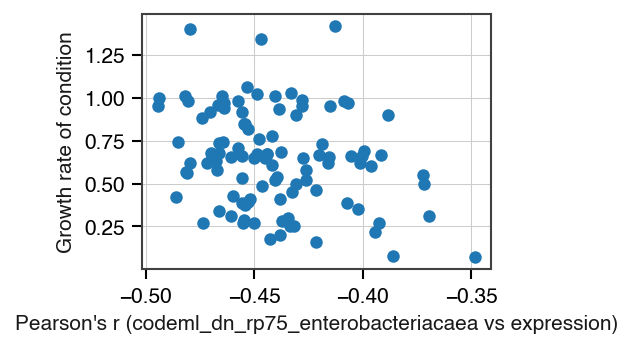

In [11]:
fig, ax = plt.subplots()
ax.plot(corrs, growth, marker='o', linestyle='')
ax.set_xlabel("Pearson's r ({} vs expression)".format(metric))
ax.set_ylabel('Growth rate of condition')
print(stats.spearmanr(corrs, growth))
print(stats.pearsonr(corrs, growth))

# Determine which expression-based summary statistics are *most* correlated with CUB metrics

In [12]:
full_df.columns

Index(['hyphy_rp75_enterobacterales', 'hyphy_rp75_enterobacteriacaea',
       'codeml_dn_rp75_enterobacterales', 'codeml_ds_rp75_enterobacterales',
       'codeml_dnds_rp75_enterobacterales',
       'codeml_dn_rp75_enterobacteriacaea',
       'codeml_ds_rp75_enterobacteriacaea',
       'codeml_dnds_rp75_enterobacteriacaea', 'count', 'mean', 'std', 'min',
       '25_percentile', '50_percentile', '75_percentile', 'max', 'cv', 'noise',
       'lin_slope', 'lin_r', 'spearmans_rho'],
      dtype='object')

In [13]:
sstats = ['mean', '50_percentile', 'max', 'min']
corrs_dict = {}

cub_corrs = []
for sstat in sstats:
    r, p = stats.pearsonr(full_df[metric], full_df[sstat])
    print(sstat, r, p)
    cub_corrs.append(r)
corrs_dict[metric] = cub_corrs
print()

mean -0.47813956298088095 4.316186982015409e-131
50_percentile -0.46876977615583765 2.1041176392240802e-125
max -0.43558008064155385 1.2604074681230655e-106
min -0.42617644985194036 1.1272152787473176e-101



[Text(0, 0, 'Mean'),
 Text(0, 0, 'Median'),
 Text(0, 0, 'Max'),
 Text(0, 0, 'Min')]

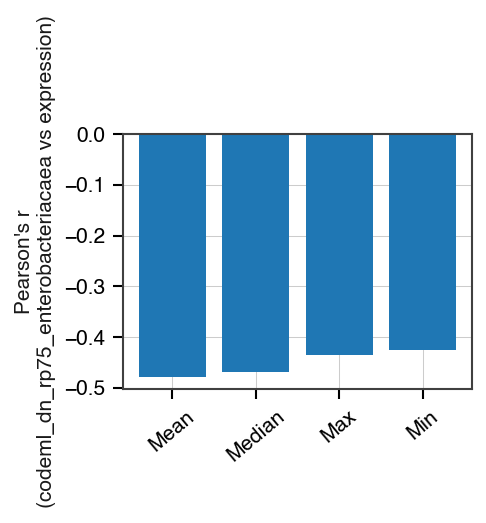

In [14]:
fig, ax = plt.subplots()
ax.bar(np.arange(len(corrs_dict[metric])), corrs_dict[metric])
ax.set_ylabel("Pearson's r\n({} vs expression)".format(metric))
ax.set_xticks(np.arange(len(corrs_dict[metric])))
ax.set_xticklabels(['Mean', 'Median', 'Max', 'Min'], rotation=40)

## Hair-brained scheme to optimize weights

In [15]:
# def custom_corr_fxn(weights, exp_df, full_df):
#     all_vals = []
#     for gene in full_df.index:
#         all_vals.append(np.average(exp_df.loc[gene], weights=weights))
#     rho, p = stats.spearmanr(all_vals, full_df['CAI'])
#     print('here {}'.format(rho))
#     return (1-rho)

In [16]:
# x0 = np.random.random(size=len(exp_df.columns))
# x0 = x0 / np.sum(x0)
# print(np.sum(x0))
# constraints = [{'type': 'eq', 'fun': lambda x: 1 - sum(x)},
#                {'type': 'ineq', 'fun': lambda x: x}]

# res = minimize(custom_corr_fxn, x0, args=(exp_df, full_df), method='SLSQP', constraints=constraints,
#                options={'maxiter': 20, 'disp': True, 'eps':1e-1})

In [17]:
# bounds = [(0,1) for i in exp_df.columns]
# def constr_f(x):
#     return np.sum(x)
# nlc = NonlinearConstraint(constr_f, 1.0, 1.0)

# res = differential_evolution(custom_corr_fxn,\
#                              bounds=np.array(bounds),\
#                              args=(exp_df, full_df),\
#                              constraints=[nlc])

In [ ]:
# fig, ax = plt.subplots()
# ax.scatter(res.x, meta_df['Growth Rate (1/hr)'])

# Regression analysis to assess predictors of ER

In [18]:
full_df.columns

Index(['hyphy_rp75_enterobacterales', 'hyphy_rp75_enterobacteriacaea',
       'codeml_dn_rp75_enterobacterales', 'codeml_ds_rp75_enterobacterales',
       'codeml_dnds_rp75_enterobacterales',
       'codeml_dn_rp75_enterobacteriacaea',
       'codeml_ds_rp75_enterobacteriacaea',
       'codeml_dnds_rp75_enterobacteriacaea', 'count', 'mean', 'std', 'min',
       '25_percentile', '50_percentile', '75_percentile', 'max', 'cv', 'noise',
       'lin_slope', 'lin_r', 'spearmans_rho'],
      dtype='object')

In [19]:
model_correlations = []

In [20]:
###Model 1, average expression
model1_params = []
fitted = smf.ols('zscore(np.log({})) ~ zscore(mean)'.format(metric), data=full_df).fit()
params = fitted.params
cis = fitted.conf_int(alpha=0.05, cols=None)
model_correlations.append(fitted.rsquared_adj)
model1_params = list(zip(params, cis.values))
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                            OLS Regression Results                                           
=============================================================================================================
Dep. Variable:     zscore(np.log(codeml_dn_rp75_enterobacteriacaea))   R-squared:                       0.324
Model:                                                           OLS   Adj. R-squared:                  0.324
Method:                                                Least Squares   F-statistic:                     1095.
Date:                                               Tue, 23 Mar 2021   Prob (F-statistic):          1.44e-196
Time:                                                       17:26:23   Log-Likelihood:                -2800.1
No. Observations:                                               2289   AIC:                             5604.
Df Residuals:                                                   2287   BIC:                             5616.
Df Model:                                                          1                                         
Covariance Type:                                           nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -4.712e-16      0.017  -2.74e-14      1.000      -0.034       0.034
zscore(mean)    -0.5690      0.017    -33.093      0.000      -0.603      -0.535
==============================================================================
Omnibus:                      174.868   Durbin-Watson:                   1.763
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              297.726
Skew:                          -0.561   Prob(JB):                     2.24e-65
Kurtosis:                       4.365   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [21]:
###Model 2, growth correlation
model2_params = []
fitted = smf.ols('zscore(np.log({})) ~ zscore(lin_r)'.format(metric), data=full_df).fit()
params = fitted.params
cis = fitted.conf_int(alpha=0.05, cols=None)
model2_params = list(zip(params, cis.values))
model_correlations.append(fitted.rsquared_adj)


fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                            OLS Regression Results                                           
=============================================================================================================
Dep. Variable:     zscore(np.log(codeml_dn_rp75_enterobacteriacaea))   R-squared:                       0.088
Model:                                                           OLS   Adj. R-squared:                  0.087
Method:                                                Least Squares   F-statistic:                     219.7
Date:                                               Tue, 23 Mar 2021   Prob (F-statistic):           1.55e-47
Time:                                                       17:26:29   Log-Likelihood:                -3143.0
No. Observations:                                               2289   AIC:                             6290.
Df Residuals:                                                   2287   BIC:                             6301.
Df Model:                                                          1                                         
Covariance Type:                                           nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -4.712e-16      0.020  -2.36e-14      1.000      -0.039       0.039
zscore(lin_r)    -0.2961      0.020    -14.823      0.000      -0.335      -0.257
==============================================================================
Omnibus:                      265.674   Durbin-Watson:                   1.677
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              506.968
Skew:                          -0.744   Prob(JB):                    8.19e-111
Kurtosis:                       4.761   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
###Model 3, all together
model3_params = []
fitted = smf.ols('zscore(np.log({})) ~ zscore(mean) + zscore(lin_r)'.format(metric), data=full_df).fit()
params = fitted.params
cis = fitted.conf_int(alpha=0.05, cols=None)
model3_params = list(zip(params, cis.values))
model_correlations.append(fitted.rsquared_adj)
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                            OLS Regression Results                                           
=============================================================================================================
Dep. Variable:     zscore(np.log(codeml_dn_rp75_enterobacteriacaea))   R-squared:                       0.335
Model:                                                           OLS   Adj. R-squared:                  0.334
Method:                                                Least Squares   F-statistic:                     575.7
Date:                                               Tue, 23 Mar 2021   Prob (F-statistic):          3.23e-203
Time:                                                       17:26:30   Log-Likelihood:                -2781.1
No. Observations:                                               2289   AIC:                             5568.
Df Residuals:                                                   2286   BIC:                             5585.
Df Model:                                                          2                                         
Covariance Type:                                           nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -4.712e-16      0.017  -2.76e-14      1.000      -0.033       0.033
zscore(mean)     -0.5301      0.018    -29.157      0.000      -0.566      -0.494
zscore(lin_r)    -0.1126      0.018     -6.196      0.000      -0.148      -0.077
==============================================================================
Omnibus:                      189.171   Durbin-Watson:                   1.777
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              338.623
Skew:                          -0.581   Prob(JB):                     2.94e-74
Kurtosis:                       4.484   Cond. No.                         1.43
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

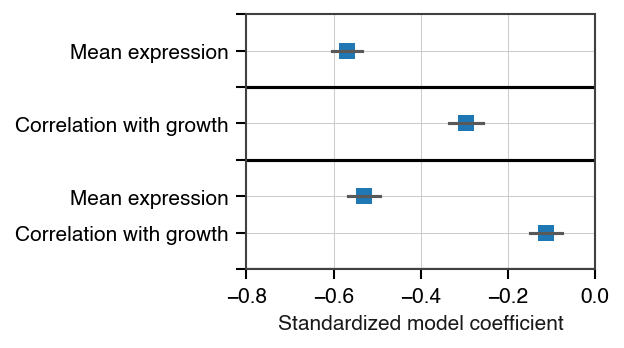

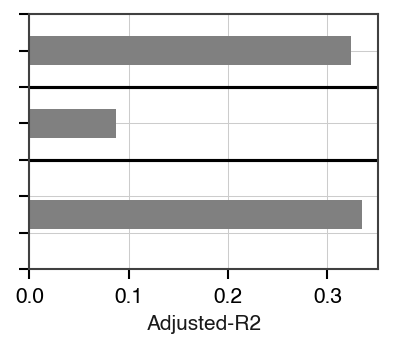

In [23]:
counter = 0
fig, ax = plt.subplots()
for model_params in [model1_params, model2_params, model3_params]:
    for i,ind_param in enumerate(model_params[1:]):
        plt.plot(ind_param[0], -i+counter, marker='s', markersize=8, color=color_cycle[0])
        plt.plot([ind_param[1][0], ind_param[1][1]], [-i+counter, -i+counter], marker='', color='0.35')
    ax.axhline(-i+counter-1, c='k')
    counter -= 2
ax.set_ylim(-6, 1)
ax.set_yticks(range(-6, 2))
labels_top_to_bottom = ['', 'Mean expression', '',\
                    'Correlation with growth', '',\
                    'Mean expression', 'Correlation with growth', '']
ax.set_yticklabels(labels_top_to_bottom[::-1])
ax.set_xlabel('Standardized model coefficient')
ax.set_xlim(-0.8, 0)

fig, ax = plt.subplots()
ax.barh(0, model_correlations[0], 0.8, facecolor='0.5')
ax.barh(-2, model_correlations[1], 0.8, facecolor='0.5')
ax.barh(-4.5, model_correlations[2], 0.8, facecolor='0.5')
ax.axhline(-1, c='k')
ax.axhline(-3, c='k')




ax.set_ylim(-6, 1)
ax.set_yticks(range(-6, 2))
ax.set_yticklabels([''])
ax.set_xlabel('Adjusted-R2');

Text(0, 0.5, 'codeml_dn_rp75_enterobacteriacaea (zscore)')

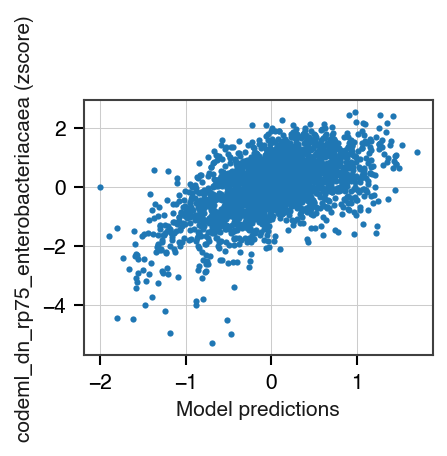

In [24]:
fig, ax = plt.subplots()
ax.plot(fitted.predict(), zscore(np.log(full_df[metric])), marker='.', linestyle='')
ax.set_xlabel('Model predictions')
ax.set_ylabel('{} (zscore)'.format(metric))

**Show that results are consistent when using with value from the highest correlation condition rather than the mean**

In [25]:
temp_df = full_df.merge(exp_df, left_index=True, right_index=True, how='inner')

In [26]:
fitted = smf.ols('zscore(np.log({})) ~ zscore(glu__glu_ale6) + zscore(lin_r)'.format(metric), data=temp_df).fit()
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                            OLS Regression Results                                           
=============================================================================================================
Dep. Variable:     zscore(np.log(codeml_dn_rp75_enterobacteriacaea))   R-squared:                       0.336
Model:                                                           OLS   Adj. R-squared:                  0.335
Method:                                                Least Squares   F-statistic:                     577.8
Date:                                               Tue, 23 Mar 2021   Prob (F-statistic):          8.07e-204
Time:                                                       17:27:04   Log-Likelihood:                -2779.7
No. Observations:                                               2289   AIC:                             5565.
Df Residuals:                                                   2286   BIC:                             5583.
Df Model:                                                          2                                         
Covariance Type:                                           nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept             -4.712e-16      0.017  -2.76e-14      1.000      -0.033       0.033
zscore(glu__glu_ale6)    -0.5612      0.019    -29.222      0.000      -0.599      -0.524
zscore(lin_r)            -0.0376      0.019     -1.956      0.051      -0.075    9.11e-05
==============================================================================
Omnibus:                      192.407   Durbin-Watson:                   1.816
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              332.049
Skew:                          -0.601   Prob(JB):                     7.88e-73
Kurtosis:                       4.428   Cond. No.                         1.65
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [30]:
fitted = smf.ols('np.log({}) ~ mean * lin_r'.format(metric), data=temp_df).fit()
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        OLS Regression Results                                       
=====================================================================================================
Dep. Variable:     np.log(codeml_dn_rp75_enterobacteriacaea)   R-squared:                       0.340
Model:                                                   OLS   Adj. R-squared:                  0.339
Method:                                        Least Squares   F-statistic:                     392.7
Date:                                       Tue, 23 Mar 2021   Prob (F-statistic):          1.10e-205
Time:                                               17:29:55   Log-Likelihood:                -2310.8
No. Observations:                                       2289   AIC:                             4630.
Df Residuals:                                           2285   BIC:                             4653.
Df Model:                                                  3                                         
Covariance Type:                                   nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.0592      0.052    -58.275      0.000      -3.162      -2.956
mean          -0.2140      0.007    -29.544      0.000      -0.228      -0.200
lin_r          0.3534      0.169      2.085      0.037       0.021       0.686
mean:lin_r    -0.0990      0.023     -4.249      0.000      -0.145      -0.053
==============================================================================
Omnibus:                      191.394   Durbin-Watson:                   1.774
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              349.378
Skew:                          -0.580   Prob(JB):                     1.36e-76
Kurtosis:                       4.523   Cond. No.                         87.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.5, 1.0, 'Adjusted-R$^2$ = 0.339')

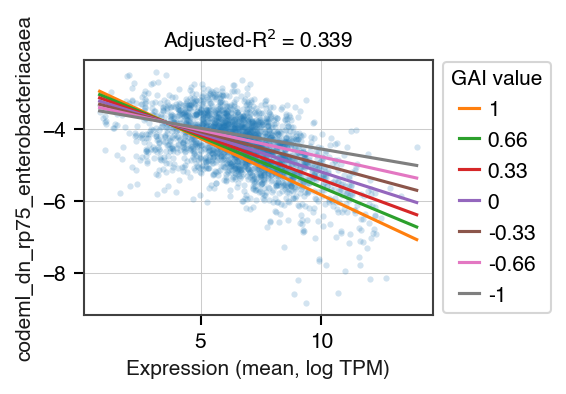

In [32]:
growth_corrs = [-1, -0.66, -0.33, 0, 0.33, 0.66, 1]
#Plot the resulting data
fig, ax = plt.subplots()
x_vals = np.linspace(temp_df['mean'].min(), temp_df['mean'].max(), 100)
ax.plot(temp_df['mean'], np.log(temp_df[metric]), marker='.', linestyle='', alpha=0.2)
for i in growth_corrs[::-1]:
    ax.plot(x_vals, fitted.params[0] +\
            (fitted.params[1]*x_vals) +\
            (fitted.params[2]*i) +\
            (fitted.params[3]*x_vals*i), label=i)
ax.set_xlabel('Expression (mean, log TPM)')
ax.set_ylabel('{}'.format(metric))
leg = ax.legend(title='GAI value', bbox_to_anchor=(1, 1.035))
plt.setp(leg.get_title(), multialignment='center')
ax.set_title('Adjusted-R$^2$ = {:.3f}'.format(fitted.rsquared_adj))

# Diagnostic plots

In [ ]:
#Categorize/bin the growth rate correlation variable
full_df['growth_cat'] = pd.qcut(full_df['lin_r'], 5, labels=[0, 1, 2, 3, 4])

In [ ]:
#And fit a fixed effect model with the categories instead of the continuous variable
fitted = smf.ols('zscore(np.log({})) ~ zscore(mean) + I(growth_cat)'.format(metric), data=full_df).fit()
fitted.summary()

In [ ]:
#Plot the resulting data
fig, ax = plt.subplots()
ax.plot(zscore(full_df['mean']), zscore(np.log(full_df[metric])), marker='.', linestyle='')
x_vals = np.linspace(-2, 3, 100)
ax.plot(x_vals, (fitted.params[-1]*x_vals)+fitted.params[0]+fitted.params[4], label='Highest')
ax.plot(x_vals, (fitted.params[-1]*x_vals)+fitted.params[0]+fitted.params[2], label='Middle')
ax.plot(x_vals, (fitted.params[-1]*x_vals)+fitted.params[0], label='Lowest')
ax.set_xlabel('Mean expression (zscore)')
ax.set_ylabel('{} (zscore)'.format(metric))
ax.legend(title='Growth rate correlation (quintile)', labelspacing=0.5, columnspacing=1,\
          ncol=3, loc=2, bbox_to_anchor=(-0.02, 1.32))


**Repeating the above with a polynomial fit**

In [ ]:
fitted = smf.ols('zscore(np.log({})) ~ np.power(zscore(mean), 2) + zscore(mean) + I(growth_cat)'.format(metric), data=full_df).fit()
fitted.summary()

In [ ]:
fig, ax = plt.subplots()
ax.plot(zscore(full_df['mean']), zscore(np.log(full_df[metric])), marker='.', linestyle='')
x_vals = np.linspace(-2, 3, 100)
low = (fitted.params[-2]*np.power(x_vals, 2))+(fitted.params[-1]*x_vals)+fitted.params[0]
med = (fitted.params[-2]*np.power(x_vals, 2))+(fitted.params[-1]*x_vals)+fitted.params[0]+fitted.params[2]
high = (fitted.params[-2]*np.power(x_vals, 2))+(fitted.params[-1]*x_vals)+fitted.params[0]+fitted.params[4]
ax.plot(x_vals, high, label='Highest')
ax.plot(x_vals, med, label='Middle')
ax.plot(x_vals, low, label='Lowest')
ax.set_xlabel('Mean expression (zscore)')
ax.set_ylabel('{} (zscore)'.format(metric))
ax.legend(title='Growth rate correlation (quintile)', labelspacing=0.5, columnspacing=1,\
          ncol=3, loc=2, bbox_to_anchor=(-0.02, 1.32))